# INSURANCE PRODUCT PREDICTION IN NAKURU

##### Objective
This project aims to predict which clusters in Nakuru County would likely buy which insurance products. <br>
Its main objective is to aid insurance companies tailor their product marketing and advertising appropriately to groups most likely to buy them, increasing the probability of a sale.

##### Dataset
The dataset used for this project is the Kenya Financial Access Dataset 2021 from the Kenya National Bureau of Statistics.<br> The dataset is very big containing over 2000 columns.<br> To ensure only reliable attributes are used, the main dataframe used for this project is a sample from the original data.

##### Attributes
- HHNo - House Hold Number
- area - Area of residence(Urban/Rural)
- age_of_respondent - Age of Questionnaire Respondent
- chronic_illness - prence of chronically ill person in the house hold
- nhif_usage - Whether the house hold has ever/currently use NHIF
- nssf_usage -  Whether the house hold has ever/curently use NSSF
- most_important_life_goal - Main goal of the house hold
- income_source - Main income source of the house hold
- total_exp_per_month - Total monthly expenditure of the house hold
- avg_mnth_income - Average monthly income of the house hold
- hse_land_loan - Taken a loan to purchase house or land
- insurance_usage, insurance_usage1, and insurance_usage2 - Usage of differnet insurance products(was not specific)
- securities_use - Has invested in securities(Green Bond, Treasury Bill, M-Akiba)
- nearest_financial_prod - Nearest financial product(Bank, Sacco, Insurance, etc) 
- TV_and_decoder - Owns a TV and Decoder
- internet_TV - Owns an internet TV
- mobile_phone - Owns a mobile phone
- fixed_internet - Has fixed internet 
- computer - Owns a computer
- refrigerator - Owns a refrigerator
- motorcycle - Owns a motorcycle
- car - Owns a car
- bus_lorry - Owns a bus or lorry
- motorboat - Owns a motorboat
- tuktuk - Owns a tuktuk
- tractor - Owns a tractor
- dairy_cattle - Rears dairy cattle
- beef_cattle - Rears beef cattle
- indigenous_cattle - Rears indigenous cattle
- sheep - Rears Sheep
- goats - Rears goats
- land_house_ownership - Owns land or a house


### Data Loading

In [4]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
import lightgbm as lgb
from lightgbm import LGBMClassifier 
from sklearn.model_selection import cross_val_score

import os
import contextlib


In [5]:
#load data
df_samples = pd.read_excel('Updated Anonymized Weighted FinAccess 2021.xlsx')
df_samples.head()

,Serial Number,County,ClusterNo,HHNo,interview__key,interview__id,A9,A9i,A10i,A14v,...,allotherformal_banked2022,formal_banked2022,excluded_informal_banked2022,NHIF_health_insurance,NHIF_ONLY,Medical_Insurance_ONLY,BothNHIF_medical,Nomedical,NHIFMedical_Cat,adults
0,1,Trans Nzoia,10226038,1048,10-67-89-46,0003fc74b3fe418ea041bd6a9e7ff387,Rural,Access granted,Female,1,...,Yes,No,Other Formal,Yes,NaN,NaN,1.0,NaN,Users of NHIF + medical insurance (C1_42 and C...,1 adult Household
1,2,Busia,10240034,1080,39-64-68-81,0004890b17744272baf0a0c7b4c20771,Rural,Access granted,Female,4,...,No,Yes,Banked,Yes,1.0,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",>1 adult Household
2,3,Machakos,10216062,1013,92-34-74-01,00052153fe8c4abaa189caadcb87b2b4,Rural,Access granted,Male,1,...,No,No,Excluded,Yes,1.0,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",1 adult Household
3,4,Kisumu,10242078,1026,08-14-22-63,000d1f8747194b6a84862830dc5fe7ca,Rural,Access granted,Male,5,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
4,5,Nyeri,10219138,1019,99-12-05-84,000f5a5c0e3246ac9a62603ad936e3da,Urban,Access granted,Male,3,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household


### Data Preparation

In [6]:
#select data from nakuru county

nakuru  = df_samples[df_samples['County'] == 'Nakuru']
nakuru.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 48 to 22019
Columns: 2332 entries, Serial Number to adults
dtypes: float64(206), int64(76), object(2050)
memory usage: 14.3+ MB


In [7]:
nakuru.head()

,Serial Number,County,ClusterNo,HHNo,interview__key,interview__id,A9,A9i,A10i,A14v,...,allotherformal_banked2022,formal_banked2022,excluded_informal_banked2022,NHIF_health_insurance,NHIF_ONLY,Medical_Insurance_ONLY,BothNHIF_medical,Nomedical,NHIFMedical_Cat,adults
48,49,Nakuru,10232202,1090,95-50-72-90,00a5d78402974eca9eb2f0e2bfb2df3b,Urban,Access granted,Female,5,...,No,No,Excluded,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
180,181,Nakuru,10232130,1067,37-30-21-49,0265fd66b5e249809eb93a6f242d1bfa,Urban,Access granted,Female,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
188,189,Nakuru,10232034,1012,76-74-21-49,0279d89f2bc4492db64a821d217afb8c,Rural,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
213,214,Nakuru,10232066,1032,46-66-78-61,02c2c43d1fd84b3ab574d312d2af93f7,Rural,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
227,228,Nakuru,10232214,1023,29-48-44-55,030ab71056c44f17a55bff4ae8a20c2f,Urban,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household


#### Data Cleaning and Preprocessing

In [8]:
#check null values
nakuru[nakuru.columns].isnull().sum()

Serial Number               0
County                      0
ClusterNo                   0
HHNo                        0
interview__key              0
                         ... 
Medical_Insurance_ONLY    799
BothNHIF_medical          802
Nomedical                 214
NHIFMedical_Cat             0
adults                      0
Length: 2332, dtype: int64

In [9]:
#drop columns with more than 3/4 of values missing
threshold = len(nakuru) * 0.75

nakuru = nakuru.dropna(thresh=threshold, axis=1)
nakuru.isnull().sum()

Serial Number                   0
County                          0
ClusterNo                       0
HHNo                            0
interview__key                  0
                               ..
formal_banked2022               0
excluded_informal_banked2022    0
NHIF_health_insurance           0
NHIFMedical_Cat                 0
adults                          0
Length: 777, dtype: int64

In [10]:
#reset index
nakuru = nakuru.reset_index()
nakuru.drop(columns='index', inplace=True)

Select features to be used:

In [198]:
nakuru_df = nakuru[['HHNo', 'A9', 'A19', 'A24','nhif_usage', 'nssf_usage','insurance_usage','insurance_usage1','insurance_usage2','B1A', 'B3B', 'B3I', 'C1_4', 'C1_5', 'C1_6', 'T1', 'U16__3', 'U16__4', 'U16__6', 'U16__7', 'U16__8', 'U16__13', 'U16__10', 'U16__11', 'U16__12', 'U16__14', 'U16__17', 'U16__18','U17i', 'U17ii', 'U17iii', 'U17iv', 'U17v', 'U19', 'U23']]
nakuru_df.head()

,HHNo,A9,A19,A24,nhif_usage,nssf_usage,insurance_usage,insurance_usage1,insurance_usage2,B1A,...,U16__14,U16__17,U16__18,U17i,U17ii,U17iii,U17iv,U17v,U19,U23
0,1090,Urban,16,No,Never had,Never had,Never had,Never had,Never had,Educating yourself or your family,...,No,No,No,0,0,0,0,0,No,7000
1,1067,Urban,27,No,Used to have,Used to have,Never had,Used to have,Used to have,Putting food on the table,...,No,No,No,0,0,0,0,0,No,20000
2,1012,Rural,22,No,Never had,Never had,Never had,Never had,Never had,Putting food on the table,...,No,No,No,0,0,0,0,0,No,10000
3,1032,Rural,29,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,No,0,0,0,0,0,No,20000
4,1023,Urban,32,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,No,0,0,0,0,0,No,10000


Rename features to understandable feature_names:

In [199]:
new_names = {'A9':'area', 'A24':'chronic_illness', 'A19':'age_of_respondent', 'B1A': 'most_important_life_goal', 'B3B':'income_source', 'B3I':'avg_mnth_income', 'C1_4':'hse_land_loan', 'C1_5':'insurance_use', 'C1_6':'securities_use', 'T1':'nearest_financial_prod', 'U16__3':'TV_and_decoder', 'U16__4':'internet_TV', 'U16__6':'mobile_phone', 'U16__7':'fixed_internet', 'U16__8':'computer', 'U16__13': 'refrigerator', 'U16__10':'motorcycle', 'U16__11':'car', 'U16__12':'bus_lorry', 'U16__14': 'motorboat', 'U16__17': 'tuktuk', 'U16__18':'tractor', 'U17i':'dairy_cattle', 'U17ii':'beef_cattle', 'U17iii': 'indigenous_cattle', 'U17iv': 'sheep', 'U17v':'goats', 'U19':'land_house_ownership', 'U23':'total_exp_per_moth'}
nakuru_df = nakuru_df.rename(columns=new_names)

In [200]:
nakuru_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   HHNo                      805 non-null    int64 
 1   area                      805 non-null    object
 2   age_of_respondent         805 non-null    int64 
 3   chronic_illness           805 non-null    object
 4   nhif_usage                805 non-null    object
 5   nssf_usage                805 non-null    object
 6   insurance_usage           805 non-null    object
 7   insurance_usage1          805 non-null    object
 8   insurance_usage2          805 non-null    object
 9   most_important_life_goal  805 non-null    object
 10  income_source             805 non-null    object
 11  avg_mnth_income           805 non-null    object
 12  hse_land_loan             805 non-null    object
 13  insurance_use             805 non-null    object
 14  securities_use            

##### Feature Engineering

Consolidate the columns 'computer', 'TV_and_decoder', 'internet_TV', 'mobile_phone', 'fixed_internet', 'refrigerator' to one feature known as electronic_device, which is the use of an electronice device in the interviewed house holds.

In [201]:
columns = ['computer', 'TV_and_decoder', 'internet_TV', 'mobile_phone', 'fixed_internet', 'refrigerator' ]

nakuru_df['electronic_device'] = nakuru_df[columns].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
nakuru_df.head()

,HHNo,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,insurance_usage,insurance_usage1,insurance_usage2,most_important_life_goal,...,tuktuk,tractor,dairy_cattle,beef_cattle,indigenous_cattle,sheep,goats,land_house_ownership,total_exp_per_moth,electronic_device
0,1090,Urban,16,No,Never had,Never had,Never had,Never had,Never had,Educating yourself or your family,...,No,No,0,0,0,0,0,No,7000,No
1,1067,Urban,27,No,Used to have,Used to have,Never had,Used to have,Used to have,Putting food on the table,...,No,No,0,0,0,0,0,No,20000,Yes
2,1012,Rural,22,No,Never had,Never had,Never had,Never had,Never had,Putting food on the table,...,No,No,0,0,0,0,0,No,10000,No
3,1032,Rural,29,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,0,0,0,0,0,No,20000,No
4,1023,Urban,32,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,0,0,0,0,0,No,10000,No


In [202]:
# same for motorvehicle ownership
columns1 = ['motorcycle', 'car', 'bus_lorry', 'motorboat', 'tuktuk', 'tractor' ]

nakuru_df['motorvehicle_ownership'] = nakuru_df[columns1].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)

In [203]:
#and livestock ownership
columns2 = ['dairy_cattle', 'beef_cattle', 'indigenous_cattle', 'sheep', 'goats']

nakuru_df['livestock_ownership'] = nakuru_df[columns2].apply(lambda row: True if True in row.values else False, axis=1)

In [204]:
#drop unused columns
nakuru_df.drop(columns=columns + columns1 + columns2, inplace=True, axis=1)

Clean feature values:

For columns with usage attributes, we integrate 'used to have' and 'currently have' to 'Yes', and 'Never had' to 'No'

Nhif and Nssf:

In [205]:
nakuru_df['nhif_usage'].unique()

array(['Never had', 'Used to have', 'Currently have'], dtype=object)

In [206]:
nakuru_df['nssf_usage'].unique()

array(['Never had', 'Used to have', 'Currently have'], dtype=object)

In [207]:
#replace values
replacements = {'Never had' : 'No', 'Used to have': 'Yes', 'Currently have': 'Yes'}
nakuru_df['nhif_usage'] = nakuru_df['nhif_usage'].replace(replacements)
nakuru_df['nssf_usage'] = nakuru_df['nssf_usage'].replace(replacements)

House and Land Loan use, Insurance use, Securities use:

In [208]:
print(nakuru_df['hse_land_loan'].unique())
print(nakuru_df['insurance_use'].unique())
print(nakuru_df['insurance_usage'].unique())
print(nakuru_df['insurance_usage1'].unique())
print(nakuru_df['insurance_usage2'].unique())
print(nakuru_df['securities_use'].unique())

['Never used' 'Currently use' 'Used to use']
['Never used' 'Currently use' 'Used to use']
['Never had' 'Currently have' 'Used to have']
['Never had' 'Used to have' 'Currently have']
['Never had' 'Used to have' 'Currently have']
['Never used' 'Used to use' 'Currently use']


In [209]:
#replace values
replacements = {'Never used' : 'No', 'Used to use': 'Yes', 'Currently use': 'Yes'}
nakuru_df['hse_land_loan'] = nakuru_df['hse_land_loan'].replace(replacements)
nakuru_df['insurance_use'] = nakuru_df['insurance_use'].replace(replacements)
nakuru_df['securities_use'] = nakuru_df['securities_use'].replace(replacements)

In [210]:
replacements = {'Never had' : 'No', 'Used to have': 'Yes', 'Currently have': 'Yes'}
nakuru_df['insurance_usage'] = nakuru_df['insurance_usage'].replace(replacements)
nakuru_df['insurance_usage1'] = nakuru_df['insurance_usage1'].replace(replacements)
nakuru_df['insurance_usage2'] = nakuru_df['insurance_usage2'].replace(replacements)

Merge ambigous insurance usage columns to one column insurance which shows whether the house holds use insurance or not:

In [211]:
#merge insurance use
columns3 = ['insurance_use', 'insurance_usage', 'insurance_usage1', 'insurance_usage2']

nakuru_df['insurance'] = nakuru_df[columns3].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
nakuru_df.drop(columns=columns3, axis=1, inplace=True)

Simplify life goal column:

In [212]:
nakuru_df['most_important_life_goal'].unique()

array(['Educating yourself or your family', 'Putting food on the table',
       'Getting a job/developing your career',
       'Starting/Improving your business/farm/ add livestock',
       'Health (yourself or family/ others)',
       'Buying land/ Building a house / improving your house',
       '"Buying assets e.g.  TV, refrigerator',
       '"Refused to Answer (DO NOT READ OUT)"',
       'None  of these (Do not read out)'], dtype=object)

In [213]:
replacements = {'Educating yourself or your family' : 'Education',
                'Putting food on the table': 'Food',
                'Getting a job/developing your career': 'Career',
                'Starting/Improving your business/farm/ add livestock': 'Business', 
                'Health (yourself or family/ others)':'Health',
                'Buying land/ Building a house / improving your house': 'Home',
                '"Buying assets e.g.  TV, refrigerator': 'Assets',
                '"Refused to Answer (DO NOT READ OUT)"':'None', 
                'None  of these (Do not read out)':'None'}
nakuru_df['most_important_life_goal'] = nakuru_df['most_important_life_goal'].replace(replacements)

Average Monthly Income:<br>
Convert 'Dont know' and 'Refused to answer' responses to N/A

In [214]:
income = nakuru_df['avg_mnth_income'].unique()
income

array([8000, 2000, '"Don\'t know(DO NOT READ OUT)"', 4000, 10000, 1000,
       3000, 15000, 300, 5000, 50000, 7000, 9000, 65000, 4500,
       '"Refused to Answer(DO NOT READ OUT)"', 6000, 70000, 20000, 200,
       3800, 22000, 100000, 44000, 500, 18000, 28000, 1500, 25000, 12000,
       16000, 30000, 7200, 21000, 8500, 11000, 6700, 2800, 24000, 40000,
       3600, 4800, 45000, 1200, 17000, 2400, 9500, 13000, 60000, 12500,
       3200, 600, 14000, 9600, 2500, 1600, 1800, 5200, 100, 80000, 7500,
       70001, 35000, 800, 27000], dtype=object)

In [215]:
replacements = {'"Don\'t know(DO NOT READ OUT)"' : np.nan, '"Refused to Answer(DO NOT READ OUT)"': np.nan}
nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].replace(replacements)

/tmp/ipykernel_200840/247140768.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Source of Income:

In [216]:
nakuru_df['income_source'].unique()

array(['Money / support from family / friends / spouse', 'Casual worker',
       'Running own business/Self employed',
       'Farming (crops, keeping livestock, fishing, aquaculture)',
       'Employed', 'Renting,  land, house/rooms, equipment',
       'Pension/Annuity', 'Money from  NGO / Government'], dtype=object)

In [217]:
replacements = {'Money / support from family / friends / spouse' : 'Family',
                'Casual worker': 'Casual_work',
                'Running own business/Self employed': 'Business', 
                'Farming (crops, keeping livestock, fishing, aquaculture)':'Agriculture',
                'Employed': 'Employment',
                'Renting,  land, house/rooms, equipment': 'Renting',
                'Pension/Annuity':'Pension', 
                'Money from  NGO / Government':'Aid'}
nakuru_df['income_source'] = nakuru_df['income_source'].replace(replacements)

Nearest Financial product:

In [218]:
nakuru_df['nearest_financial_prod'].unique()

array(['Mobile Money Agent (for depositing or withdrawing cash)',
       'Bank Agent/ Post Bank Agent', '"Don\'t know(DO NOT READ OUT)"',
       'Bank/Post Bank Branch/ Head Office/ ATM', nan,
       'Insurance company/ agent'], dtype=object)

In [219]:
replacements = {'Mobile Money Agent (for depositing or withdrawing cash)' : 'MMoney',
                'Bank Agent/ Post Bank Agent': 'Bank',
                'Bank/Post Bank Branch/ Head Office/ ATM': 'Bank', 
                'Insurance company/ agent':'Insurance',
                '"Don\'t know(DO NOT READ OUT)"': pd.NA}
nakuru_df['nearest_financial_prod'] = nakuru_df['nearest_financial_prod'].replace(replacements)

Land and house ownership:

In [220]:
nakuru_df['land_house_ownership'].unique()

array(['No', 'Yes', nan, '"Refused to Answer (DO NOT READ OUT)"'],
      dtype=object)

In [221]:
replacements = {'"Refused to Answer (DO NOT READ OUT)"': pd.NA}
nakuru_df['land_house_ownership'] = nakuru_df['land_house_ownership'].replace(replacements)

In [222]:
#check missing values
nakuru_df.isnull().sum()

HHNo                          0
area                          0
age_of_respondent             0
chronic_illness               0
nhif_usage                    0
nssf_usage                    0
most_important_life_goal      0
income_source                 0
avg_mnth_income             106
hse_land_loan                 0
securities_use                0
nearest_financial_prod        7
land_house_ownership          3
total_exp_per_moth            2
electronic_device             0
motorvehicle_ownership        0
livestock_ownership           0
insurance                     0
dtype: int64

In [223]:
nakuru_df.to_csv('Nakuru_FinAccess1.csv', index=False)

Impute the missing values of the average monthly income by the mean value:

In [224]:
nakuru_df['avg_mnth_income'] = pd.to_numeric(nakuru_df['avg_mnth_income'], errors='coerce')

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
nakuru_df['avg_mnth_income']= imputer.fit_transform(nakuru_df[['avg_mnth_income']])
nakuru_df['avg_mnth_income'].isnull().sum()

np.int64(0)

In [225]:
#drop missing values
nakuru_df = nakuru_df.dropna(axis=0)
nakuru_df.isnull().sum()

HHNo                        0
area                        0
age_of_respondent           0
chronic_illness             0
nhif_usage                  0
nssf_usage                  0
most_important_life_goal    0
income_source               0
avg_mnth_income             0
hse_land_loan               0
securities_use              0
nearest_financial_prod      0
land_house_ownership        0
total_exp_per_moth          0
electronic_device           0
motorvehicle_ownership      0
livestock_ownership         0
insurance                   0
dtype: int64

## Exploratory Data Analysis

#### Distribution of attributes

array([[<Axes: title={'center': 'avg_mnth_income'}>]], dtype=object)

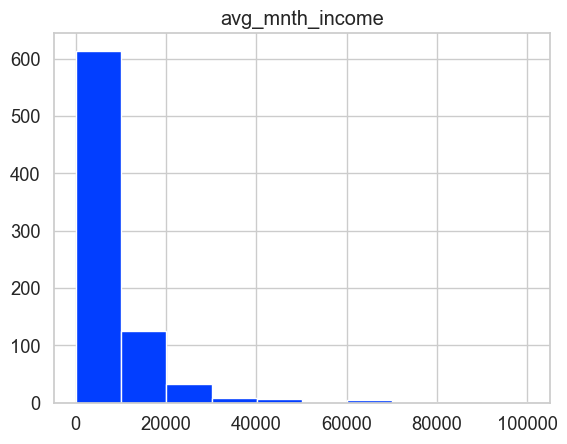

In [226]:
#average monthly income distribution
nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].astype('int')

nakuru_df.hist(column='avg_mnth_income')

Majority of the sample earn an average monthly income below 10,000/=

In [227]:
#distribution of income by area and insurance use

fig = px.box(nakuru_df, x='area', y='avg_mnth_income')
fig.show()

People living in the urban areas earn a little bit more than those living in the rural areas. 

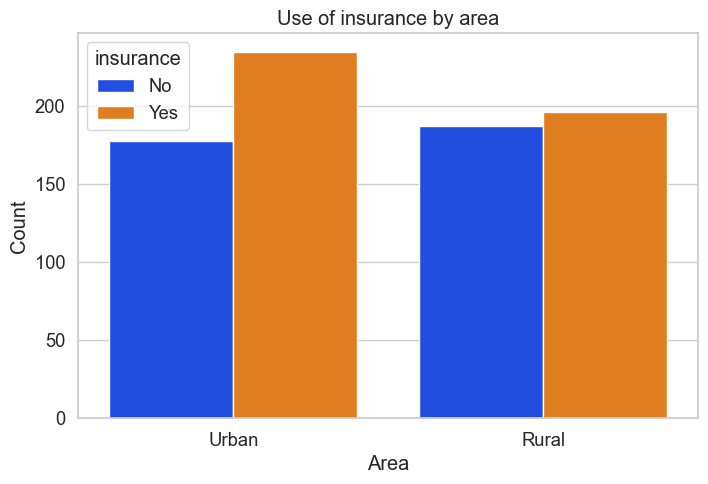

In [228]:
plt.figure(figsize=(8, 5))
sns.countplot(x='area', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by area')
plt.xlabel('Area')
plt.ylabel('Count')
plt.show()

People living in urban areas use insurance more than those living in rural areas.

In [229]:
income_avg_by_insurance = nakuru_df.groupby('insurance')['avg_mnth_income'].describe()
income_avg_by_insurance

,count,mean,std,min,25%,50%,75%,max
insurance,,,,,,,,
No,365.0,7278.750685,7389.269536,100.0,3000.0,6000.0,9872.0,100000.0
Yes,431.0,12021.051044,11873.207340,500.0,5000.0,9872.0,15000.0,80000.0


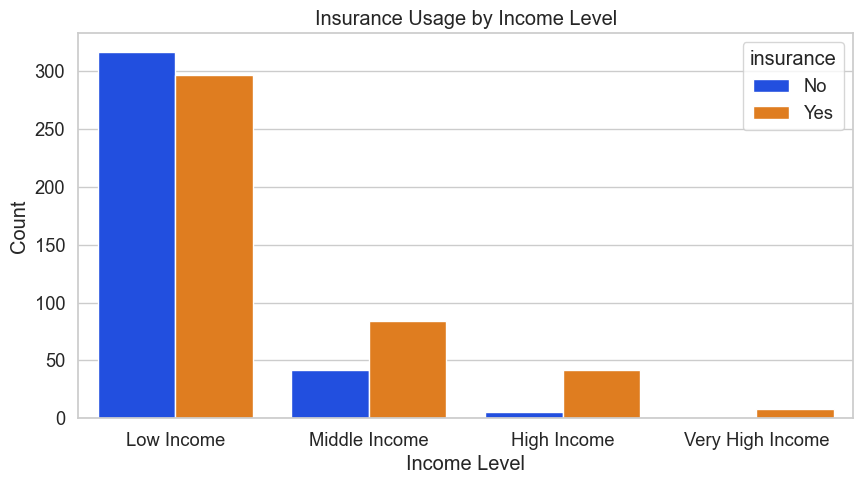

In [230]:
nakuru_df['income_bins'] = pd.cut(nakuru_df['avg_mnth_income'], bins=[0, 10000, 20000, 50000, nakuru_df['avg_mnth_income'].max()],
                             labels=['Low Income', 'Middle Income', 'High Income', 'Very High Income'])

# Bar plot for insurance usage across income bins
plt.figure(figsize=(10, 5))
sns.countplot(x='income_bins', hue='insurance', data=nakuru_df)
plt.title('Insurance Usage by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.show()

Low income earners are less likely to use insurance products comprared to middle, high, and very high income earners.

In [231]:
nakuru_df = nakuru_df.rename({'total_exp_per_moth':'total_exp_per_month'}, axis=1)
nakuru_df['total_exp_per_month'] = nakuru_df['total_exp_per_month'].astype('int')

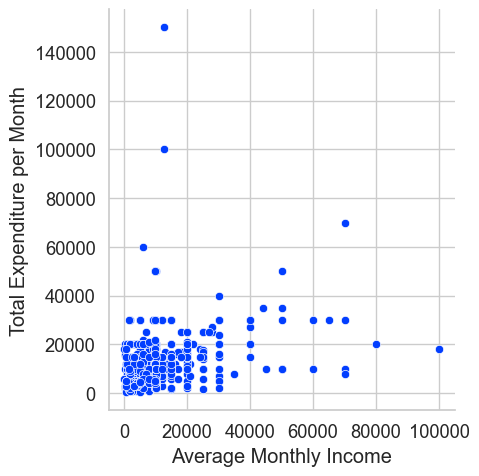

In [232]:
#avg income vs total expenditure

g = sns.relplot(data=nakuru_df, x='avg_mnth_income', y='total_exp_per_month')
g.set_axis_labels("Average Monthly Income", "Total Expenditure per Month")
plt.show()

Most of the house holds live within their wage. There are a few who either spend above or below their income level.

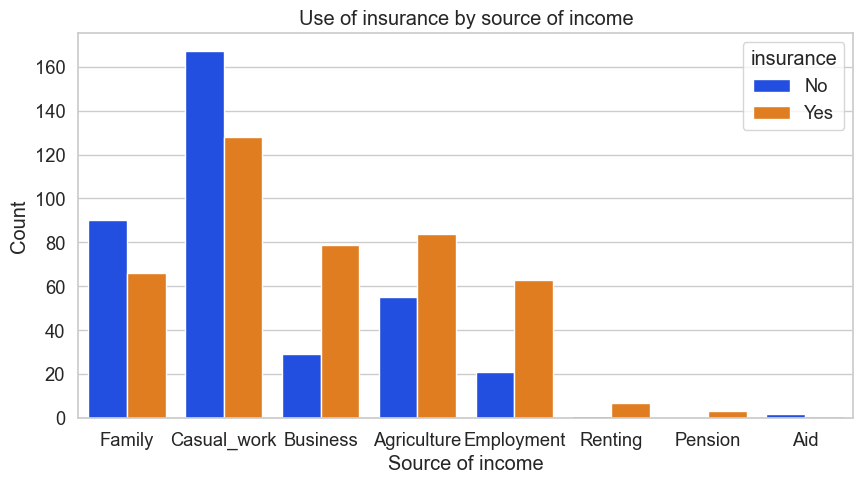

In [233]:
#insurance use vs source of income

plt.figure(figsize=(10, 5))
sns.countplot(x='income_source', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by source of income')
plt.xlabel('Source of income')
plt.ylabel('Count')
plt.show()

People with some sort of consistent employment(business, agriculture, etc) are more likely to use insurance, whereas those who depend on casual work or help for income are less likely to use insurance.

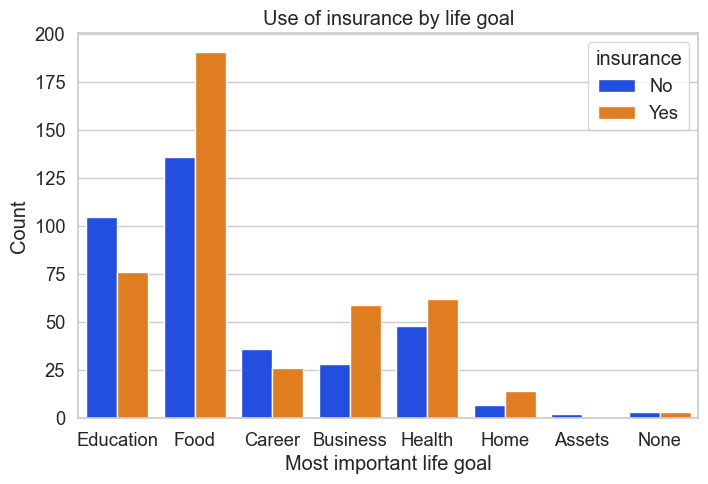

In [234]:
#insurance use by life goal
plt.figure(figsize=(8, 5))

sns.countplot(x='most_important_life_goal', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by life goal')
plt.xlabel('Most important life goal')
plt.ylabel('Count')
plt.show()

The households whose main goals are to put food on the table, improve business, buy land or build a home, and cater for health needs, tend to most likely use an insurance product. Households who prioritize furthering of education as well as career tend to least use insurance products.

### Clustering

##### Prepare data for clustering

Drop columns that are not to be used for clustering:

In [235]:
cluster_data = nakuru_df.drop(columns=['HHNo', 'income_bins'])


Scale the numeric columns using StandardScaler:

In [236]:
#scale numerical columns

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']])

pd.DataFrame(scaled_data)

,0,1,2
0,-1.357373,-0.178754,-0.425970
1,-0.682770,-0.759595,0.892056
2,-0.989408,0.002468,-0.121810
3,-0.560115,0.002468,0.892056
4,-0.376132,-0.178754,-0.121810
...,...,...,...
791,-0.437460,-0.275561,1.398990
792,-0.621442,-0.662788,0.385123
793,0.482454,0.208473,-0.121810
794,-0.805425,0.002468,0.486510


In [237]:
cluster_data[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']] = scaled_data


In [238]:
cluster_data.head()

,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,most_important_life_goal,income_source,avg_mnth_income,hse_land_loan,securities_use,nearest_financial_prod,land_house_ownership,total_exp_per_month,electronic_device,motorvehicle_ownership,livestock_ownership,insurance
0,Urban,-1.357373,No,No,No,Education,Family,-0.178754,No,No,MMoney,No,-0.425970,No,No,False,No
1,Urban,-0.682770,No,Yes,Yes,Food,Family,-0.759595,No,No,MMoney,No,0.892056,Yes,Yes,False,Yes
2,Rural,-0.989408,No,No,No,Food,Casual_work,0.002468,No,No,MMoney,No,-0.121810,No,Yes,False,No
3,Rural,-0.560115,No,No,No,Career,Family,0.002468,No,Yes,MMoney,No,0.892056,No,No,False,No
4,Urban,-0.376132,No,No,No,Career,Casual_work,-0.178754,No,No,MMoney,No,-0.121810,No,No,False,No


Encode categorical columns:

In [239]:
cat_cols = ['most_important_life_goal', 'area', 'income_source', 'nearest_financial_prod']

encoded = pd.get_dummies(cluster_data[cat_cols])
encoded


,most_important_life_goal_Assets,most_important_life_goal_Business,most_important_life_goal_Career,most_important_life_goal_Education,most_important_life_goal_Food,most_important_life_goal_Health,most_important_life_goal_Home,most_important_life_goal_None,area_Rural,area_Urban,...,income_source_Aid,income_source_Business,income_source_Casual_work,income_source_Employment,income_source_Family,income_source_Pension,income_source_Renting,nearest_financial_prod_Bank,nearest_financial_prod_Insurance,nearest_financial_prod_MMoney
0,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
1,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,True,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
801,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
802,False,False,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
803,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


Concatenate the data to be used in the clustering:

In [240]:
model_data = pd.concat([cluster_data.drop(cat_cols, axis=1), encoded], axis=1)
model_data

,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,avg_mnth_income,hse_land_loan,securities_use,land_house_ownership,total_exp_per_month,electronic_device,...,income_source_Aid,income_source_Business,income_source_Casual_work,income_source_Employment,income_source_Family,income_source_Pension,income_source_Renting,nearest_financial_prod_Bank,nearest_financial_prod_Insurance,nearest_financial_prod_MMoney
0,-1.357373,No,No,No,-0.178754,No,No,No,-0.425970,No,...,False,False,False,False,True,False,False,False,False,True
1,-0.682770,No,Yes,Yes,-0.759595,No,No,No,0.892056,Yes,...,False,False,False,False,True,False,False,False,False,True
2,-0.989408,No,No,No,0.002468,No,No,No,-0.121810,No,...,False,False,True,False,False,False,False,False,False,True
3,-0.560115,No,No,No,0.002468,No,Yes,No,0.892056,No,...,False,False,False,False,True,False,False,False,False,True
4,-0.376132,No,No,No,-0.178754,No,No,No,-0.121810,No,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,-0.437460,No,No,No,-0.275561,No,No,No,1.398990,No,...,False,False,False,False,True,False,False,False,False,True
801,-0.621442,No,No,Yes,-0.662788,No,No,No,0.385123,Yes,...,False,False,False,False,True,False,False,False,False,True
802,0.482454,No,No,No,0.208473,No,No,Yes,-0.121810,Yes,...,False,False,True,False,False,False,False,False,False,True
803,-0.805425,No,No,No,0.002468,No,No,No,0.486510,No,...,False,False,False,False,False,False,False,False,False,True


In [241]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 0 to 804
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_of_respondent                   796 non-null    float64
 1   chronic_illness                     796 non-null    object 
 2   nhif_usage                          796 non-null    object 
 3   nssf_usage                          796 non-null    object 
 4   avg_mnth_income                     796 non-null    float64
 5   hse_land_loan                       796 non-null    object 
 6   securities_use                      796 non-null    object 
 7   land_house_ownership                796 non-null    object 
 8   total_exp_per_month                 796 non-null    float64
 9   electronic_device                   796 non-null    object 
 10  motorvehicle_ownership              796 non-null    object 
 11  livestock_ownership                 796 non-null  

In [242]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 0 to 804
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_of_respondent                   796 non-null    float64
 1   chronic_illness                     796 non-null    object 
 2   nhif_usage                          796 non-null    object 
 3   nssf_usage                          796 non-null    object 
 4   avg_mnth_income                     796 non-null    float64
 5   hse_land_loan                       796 non-null    object 
 6   securities_use                      796 non-null    object 
 7   land_house_ownership                796 non-null    object 
 8   total_exp_per_month                 796 non-null    float64
 9   electronic_device                   796 non-null    object 
 10  motorvehicle_ownership              796 non-null    object 
 11  livestock_ownership                 796 non-null  

#### Clustering using KPrototypes

Since our data is divided between numerical and categorical variables, we will use Kprototypes for clustering:

In [243]:
#getting the categorical and numeric attribute indices
num_column_indices = [0, 4, 8]

cat_column_indices = []
for i in range(len(model_data.columns)):
        if i not in num_column_indices:
            cat_column_indices.append(i)

cat_column_indices

[1,
 2,
 3,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

Determining the best cluster value for our data:<br>
We will determing this by using:
- Elbow curve method of the costs after fitting the data using a range of clusters
- Silhouette Score

In [244]:
# Define the range of potential clusters 
clusters_range = range(2, 10)
costs = []

for n_clusters in clusters_range:
        kproto = KPrototypes(n_clusters=n_clusters, init='Huang')
        clusters = kproto.fit_predict(model_data, categorical=cat_column_indices)
        costs.append(kproto.cost_)
print(costs)

[np.float64(3804.860359496603), np.float64(3203.035113500516), np.float64(2914.522353029319), np.float64(2713.1779162767407), np.float64(2554.6220671429246), np.float64(2455.783895584831), np.float64(2312.101299348032), np.float64(2273.5263286517848)]


In [245]:
print(len(clusters_range))
print(len(costs))

8
8


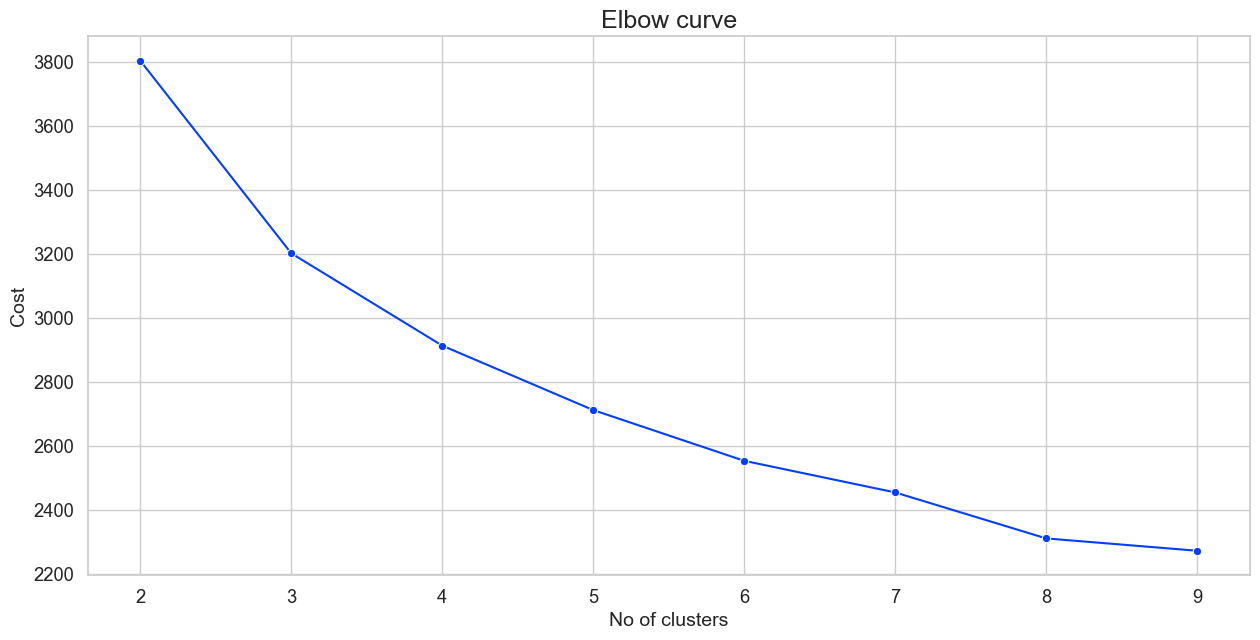

In [246]:
#Elbow Curve of the costs
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=clusters_range, y=costs, marker="o", dashes=False)
ax.set_title('Elbow curve', fontsize=18)
ax.set_xlabel('No of clusters', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
plt.plot();

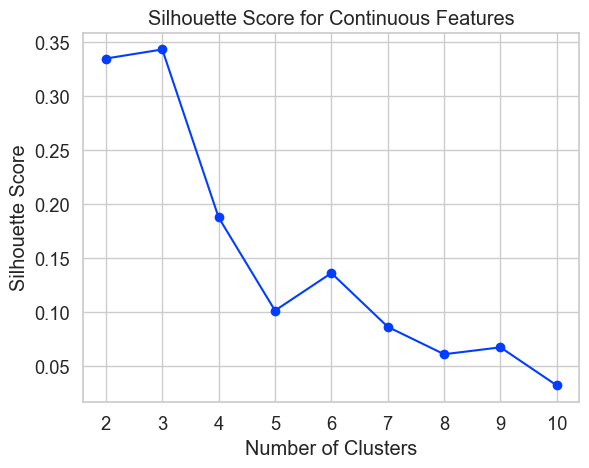

In [247]:
#Silhouette Score
sil_scores = []
for num_clusters in range(2, 11):  # Start from 2 clusters
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42)
    clusters = kproto.fit_predict(model_data, categorical=[i for i in range(model_data.shape[1]) if i not in num_column_indices])
    
    # Silhouette score for numerical attributes
    silhouette_avg = silhouette_score(model_data.iloc[:, num_column_indices], clusters, metric='euclidean')
    sil_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Continuous Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Both the Elbow method analysis of costs and silhouette score analysis for continuous variables show the best number of clusters to use is 3.

Fit the model using 3 clusters:

In [248]:
model_3 = KPrototypes(n_clusters=3, init='Huang', random_state=42, n_jobs=-1)
clusters = model_3.fit_predict(model_data, categorical=cat_column_indices)

#### Clustering Evaluation

We will use LGBMClassifier to check how well the clusters are separated

In [249]:
#convert categorical columns to bool for the model
cols = model_data.select_dtypes(include=['object']).columns
model_data[cols] = model_data[cols].astype('bool')
model_data[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 0 to 804
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   chronic_illness         796 non-null    bool 
 1   nhif_usage              796 non-null    bool 
 2   nssf_usage              796 non-null    bool 
 3   hse_land_loan           796 non-null    bool 
 4   securities_use          796 non-null    bool 
 5   land_house_ownership    796 non-null    bool 
 6   electronic_device       796 non-null    bool 
 7   motorvehicle_ownership  796 non-null    bool 
 8   insurance               796 non-null    bool 
dtypes: bool(9)
memory usage: 13.2 KB


In [250]:
#fit the data and print the F1 Score
clf_kp = LGBMClassifier()
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    cv_scores_kp = cross_val_score(clf_kp, model_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9353780469746686


An F1 score of 0.93 show that our model performed quite well and the clusters are well separated.

#### Cluster Analysis

We will use SHAP values as well as atrribute analysis to determine the different cluster characteristics.

In [251]:
#getting Shap values
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    clf_kp.fit(model_data, clusters)
explainer_kp = shap.Explainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(model_data)


In [252]:
#add clusters to data
nakuru_df['Clusters'] = clusters
nakuru_df.head()

,HHNo,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,most_important_life_goal,income_source,avg_mnth_income,hse_land_loan,securities_use,nearest_financial_prod,land_house_ownership,total_exp_per_month,electronic_device,motorvehicle_ownership,livestock_ownership,insurance,income_bins,Clusters
0,1090,Urban,16,No,No,No,Education,Family,8000,No,No,MMoney,No,7000,No,No,False,No,Low Income,1
1,1067,Urban,27,No,Yes,Yes,Food,Family,2000,No,No,MMoney,No,20000,Yes,Yes,False,Yes,Low Income,1
2,1012,Rural,22,No,No,No,Food,Casual_work,9872,No,No,MMoney,No,10000,No,Yes,False,No,Low Income,1
3,1032,Rural,29,No,No,No,Career,Family,9872,No,Yes,MMoney,No,20000,No,No,False,No,Low Income,1
4,1023,Urban,32,No,No,No,Career,Casual_work,8000,No,No,MMoney,No,10000,No,No,False,No,Low Income,1


In [253]:
nakuru_df.to_csv('Nakuru_FinAccess.csv', index=False)

In [254]:
#get the different cluster data
cluster1 = nakuru_df[nakuru_df['Clusters'] == 0]
cluster2 = nakuru_df[nakuru_df['Clusters'] == 1]
cluster3 = nakuru_df[nakuru_df['Clusters'] == 2]

We will now analyse the chracteristics of each cluster.<br> We will be focusing on the top 5 contributing attributes of each cluster which we will get by plotting the shap values of the different clusters.

##### Cluster 1 Analysis

SHAP Summary for Cluster 1


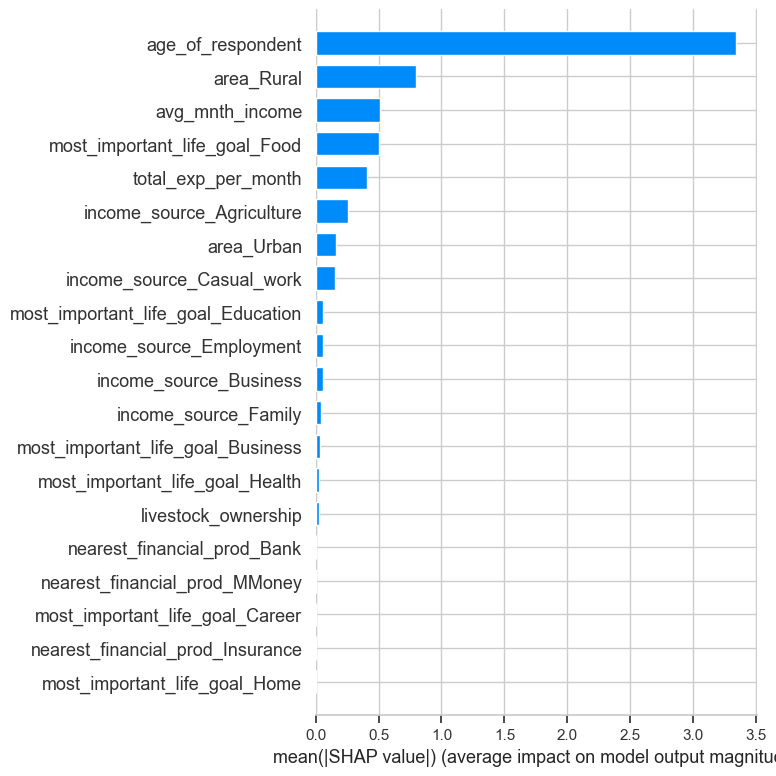

In [255]:
#plot shap values for cluster 1
print("SHAP Summary for Cluster 1")
shap_values_for_cluster1 = shap_values_kp[:, :, 0]
shap.summary_plot(shap_values_for_cluster1, model_data, plot_type="bar", plot_size=(8, 8))

For Cluster 1 we have:
- Age of respondent
- Average monthly income
- Area
- Most important life goal
- Total Expenditure
- Income source.




In [256]:
# numerical attributes
cluster1_num = cluster1[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']]
cluster1_num.describe()


,age_of_respondent,avg_mnth_income,total_exp_per_month
count,224.000000,224.000000,224.000000
mean,57.383929,6945.303571,7578.571429
std,13.311882,4930.896877,5023.146934
min,32.000000,200.000000,800.000000
25%,47.750000,3000.000000,4000.000000
50%,57.500000,5000.000000,6000.000000
75%,66.000000,9872.000000,10000.000000
max,98.000000,25000.000000,30000.000000


Lets check the distribution:

<Axes: ylabel='Frequency'>

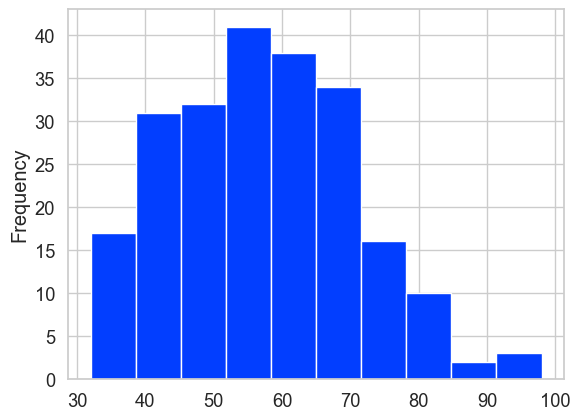

In [257]:
cluster1['age_of_respondent'].plot(kind='hist')

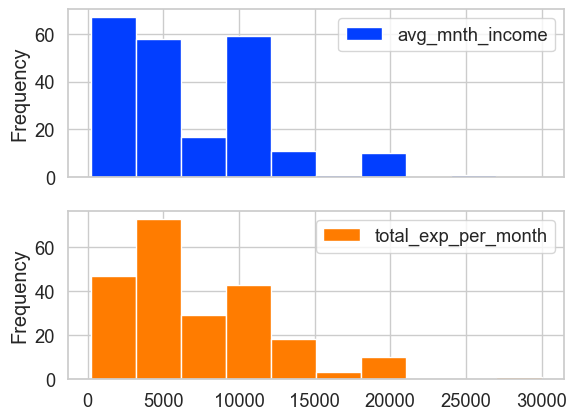

In [258]:
cluster1_num[['avg_mnth_income', 'total_exp_per_month']].plot(subplots=True, kind='hist')
plt.show()

- Most house holds from cluster 1 earn 15000 shillings and below with few going to 30000.
- The case is same for monthly income expenditure.


Cluster 1 Profile:
* Mean average monthly income is about 7000 ranging between 200 to 25000 shillings(most under 10000)
* Average monthly expenditure is about 7500 ranging between 800 to 30000 shillings(most under 10000)
* Live in a rural area of Nakuru county
* Young to middled aged with an average of 57 and ranges between 32 to 98 years(most below 66) 
* Main source of income is Agriculture

Description: 
- Older low income farmers.

Probable insurance products:
- Agriculture Insurance

##### Cluster 2 analysis

SHAP Summary for Cluster 2


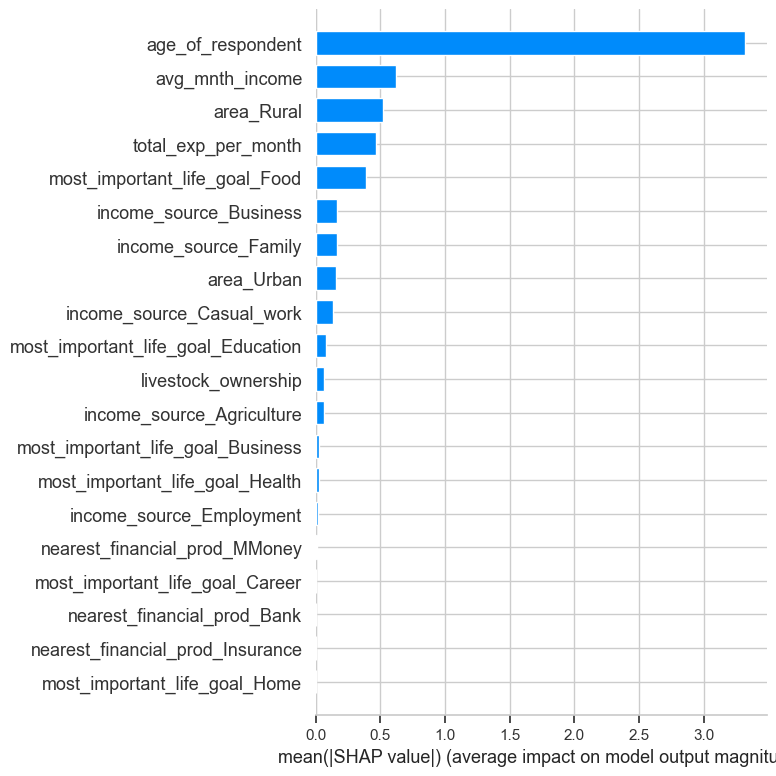

In [259]:
#shap values for cluster 2
print("SHAP Summary for Cluster 2")
shap_values_for_cluster2 = shap_values_kp[:, :, 1]
shap.summary_plot(shap_values_for_cluster2, model_data, plot_type="bar", plot_size=(8, 8))

For Cluster 2 we have:
- Age of respondent 
- Average monthly income
- Area
- Total Expenditure per month
- Life goal
- Income source


Analysis of the numerical columns:

In [260]:
#numerical statistics
cluster2[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']].describe()

,age_of_respondent,avg_mnth_income,total_exp_per_month
count,496.000000,496.000000,496.000000
mean,28.939516,7836.362903,10351.108871
std,7.956217,5154.357723,5742.361970
min,16.000000,100.000000,500.000000
25%,23.000000,4000.000000,6000.000000
50%,28.000000,8000.000000,10000.000000
75%,35.000000,10000.000000,15000.000000
max,52.000000,30000.000000,30000.000000


<Axes: ylabel='Frequency'>

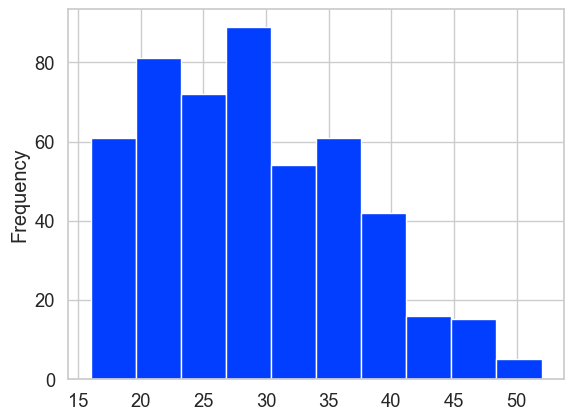

In [261]:
cluster2['age_of_respondent'].plot(kind='hist')

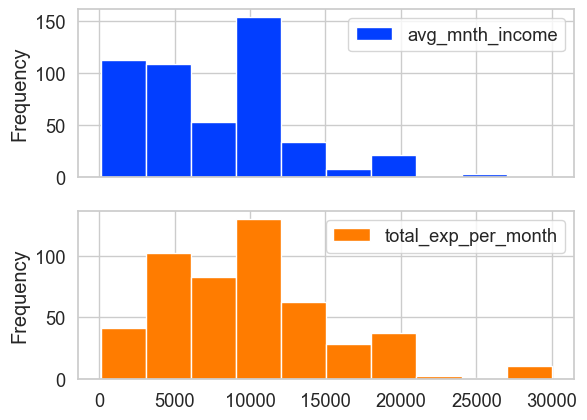

In [262]:
cluster2[['avg_mnth_income', 'total_exp_per_month']].plot(subplots=True, kind='hist')
plt.show()

Cluster 2 profile:
- Mean average monthly income of about 8000 shillings ranging between 100 to 30000(most below 10000)
- Mean monthly expenditure of 10000 shillings ranging between 500 to 30000(most below 15000) 
- Income source is Business
- Living in the Rural area of Nakuru County
- Average age of 28 years ranging between 16 to 52(most are below 35)


Description:
- young owners of small businesses

Probable insurance product:
- Business property insurance
- General liability insurance
- Professional liability insurance(if applicable to the business)

Cluster 3:


SHAP Summary for Cluster 3


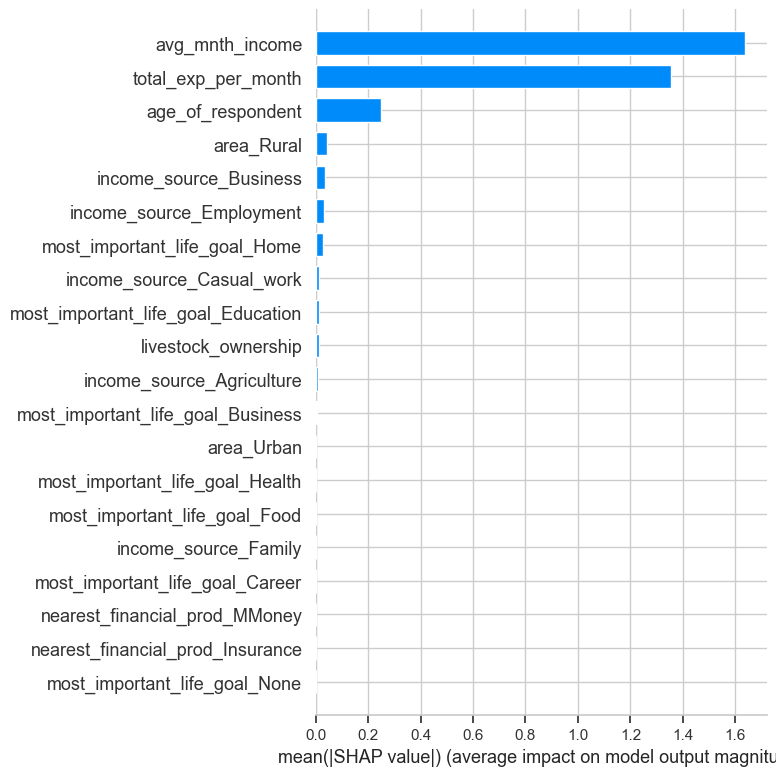

In [263]:
#shap values for cluster 3
print("SHAP Summary for Cluster 3")
shap_values_for_cluster3 = shap_values_kp[:, :, 2]
shap.summary_plot(shap_values_for_cluster3, model_data, plot_type="bar", plot_size=(8, 8))

For Cluster 3 we have:
- Average monthly income
- Total Expenditure per month
- Age of the respondent
- Area 
- Income source


Analysis of numeric columns:

In [264]:
cluster3[['avg_mnth_income', 'total_exp_per_month', 'age_of_respondent']].describe()

,avg_mnth_income,total_exp_per_month,age_of_respondent
count,76.000000,76.000000,76.000000
mean,31516.223684,27428.947368,41.394737
std,18898.916830,20712.758167,14.163878
min,6000.000000,2000.000000,19.000000
25%,20000.000000,17450.000000,30.000000
50%,28000.000000,25000.000000,39.500000
75%,40000.000000,30000.000000,52.000000
max,100000.000000,150000.000000,78.000000


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

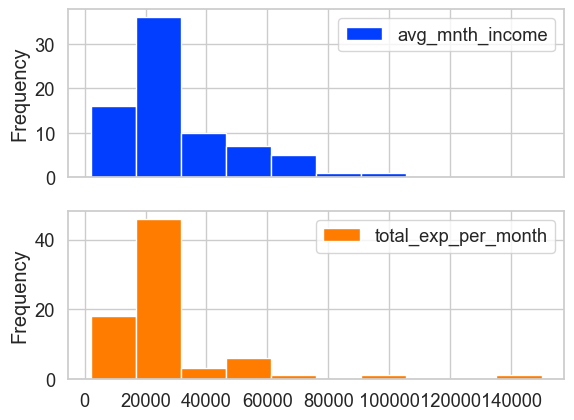

In [265]:
cluster3[['avg_mnth_income', 'total_exp_per_month']].plot(subplots=True, kind='hist')

<Axes: ylabel='Frequency'>

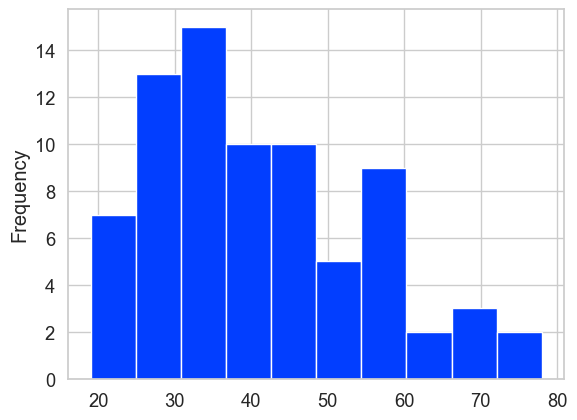

In [266]:
cluster3['age_of_respondent'].plot(kind='hist')

Cluster 3 profile:
Most important attributes:
- Mean average monthly income of about 30000 shillings, ranging from 6000 to 100000(most under 40000)
- Mean expenditure of about 27500 shillings, ranging from 2000 to 15000(most under 30000)
- Mean respondents age is 41, ranging from 19 to 78(most below 52 years)
- Income source is business

Description:
- Middle aged, average sized business owners 

Probable Insurance product:
- Workers compensation Insurance(if applicable)
- Business property insurance
- Product liability insurance
- Life insurance
